### Importing all necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import cm
import geopandas as gpd
import plotly.express as px
import seaborn as sns
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)    #THIS LINE IS MOST IMPORTANT AS THIS WILL DISPLAY PLOT ON 
#NOTEBOOK WHILE KERNEL IS RUNNING
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.display import HTML,display
import warnings
warnings.filterwarnings("ignore")
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.pyplot as py
from scipy import stats

### Importing main dataset

In [2]:
df = pd.read_csv('covid_19_india.csv', parse_dates=['Date'],dayfirst=True)

### Importing tests dataset

In [3]:
tests = pd.read_csv('StatewiseTestingDetails.csv' )

### Eyeballing on the datasets

In [4]:
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9291 entries, 0 to 9290
Data columns (total 9 columns):
Sno                         9291 non-null int64
Date                        9291 non-null datetime64[ns]
Time                        9291 non-null object
State/UnionTerritory        9291 non-null object
ConfirmedIndianNational     9291 non-null object
ConfirmedForeignNational    9291 non-null object
Cured                       9291 non-null int64
Deaths                      9291 non-null int64
Confirmed                   9291 non-null int64
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 653.4+ KB


In [6]:
#keeping only required columns
df = df[['Date','State/UnionTerritory','Cured','Deaths','Confirmed']]
#renaming column names
df.columns = [ 'date','state','cured','deaths','confirmed']

In [7]:
#keeping only required columns
tests = tests[['Date', 'State','TotalSamples','Negative','Positive']]
#renaming column names
tests.columns = ['date', 'state','total_samples','negative','positive']

In [8]:
tests['negative'][tests['negative'].isna()]=tests['total_samples']-tests['positive']

In [9]:
df

,date,state,cured,deaths,confirmed
0,2020-01-30,Kerala,0,0,1
1,2020-01-31,Kerala,0,0,1
2,2020-02-01,Kerala,0,0,2
3,2020-02-02,Kerala,0,0,3
4,2020-02-03,Kerala,0,0,3
...,...,...,...,...,...
9286,2020-12-09,Telengana,266120,1480,275261
9287,2020-12-09,Tripura,32169,373,32945
9288,2020-12-09,Uttarakhand,72435,1307,79141
9289,2020-12-09,Uttar Pradesh,528832,7967,558173


### EDA on the datasets

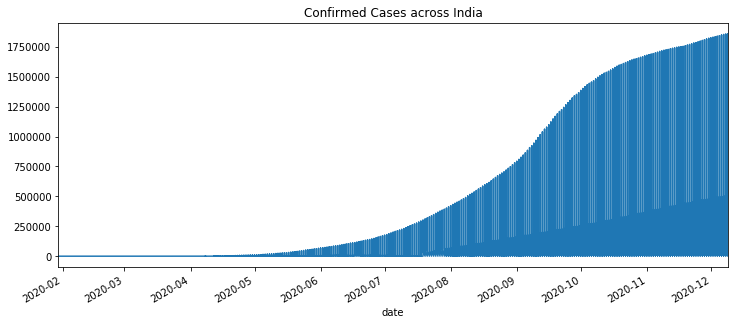

In [10]:
df3 = df.copy()
df3.index = df3['date']
df3.drop('date',axis=1)
df3['confirmed'].plot(figsize=(12,5), title="Confirmed Cases across India").autoscale(axis='x',tight=True)

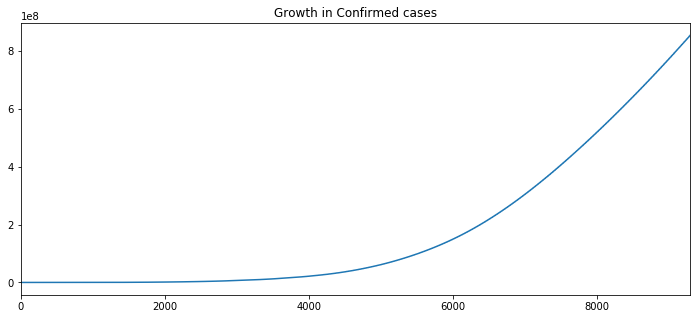

In [11]:
df['confirmed'].expanding().sum().plot(figsize=(12,5), title = "Growth in Confirmed cases")

In [12]:
#current date
today = df[df.date == '2020-07-14']

gdf = gpd.read_file('Indian_States.shp')
#renaming state names
gdf['st_nm'].replace({"Andaman & Nicobar Island": "Andaman and Nicobar Islands",
                      "Arunanchal Pradesh": "Arunachal Pradesh",
                      'Dadara & Nagar Havelli':'Dadra and Nagar Haveli and Daman and Diu',
                      'Jammu & Kashmir':'Jammu and Kashmir',
                      'NCT of Delhi':'Delhi'}, inplace=True)
merged = gdf.merge(today ,  left_on='st_nm', right_on='state')
merged.state.replace({"Andaman and Nicobar Islands" : "A & N",
                      'Dadra and Nagar Haveli and Daman and Diu' : 'Daman & Diu',
                      'Jammu and Kashmir' : 'J & K'
                      }, inplace=True)



confirmed = merged.sort_values('confirmed', ascending = True)

lowc = confirmed.head(10)
highc = confirmed.tail(10)


fig = px.bar(confirmed, x="confirmed", y="state", orientation='h', text = 'confirmed')
fig.update_layout(
    title_text='<b>Confirmed cases of Covid-19 per State <b>',
    title_x=0.5,
    paper_bgcolor='aqua',
    plot_bgcolor = "aqua",
    autosize=False,
    width= 850,
    height=850)
fig.update_traces(marker_color='teal')
fig.update_xaxes(tickfont=dict(family='Rockwell', color='black', size=14))
fig.update_yaxes(tickfont=dict(family='Rockwell', color='black', size=14))
fig.show()

### Effect of lockdown in Delhi state

Text(08/06/20, 5000, 'Unlock 1.0')

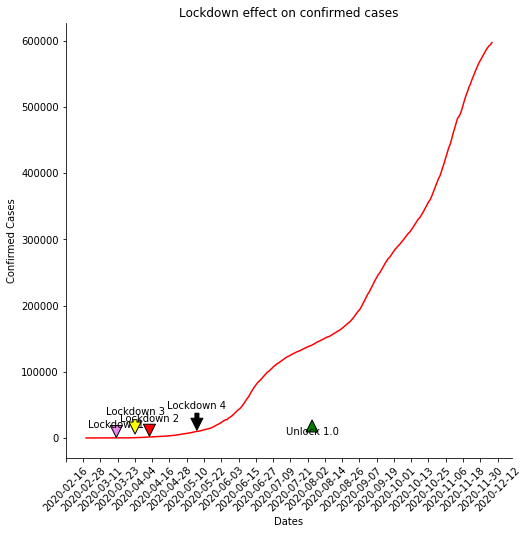

In [13]:
#df_m = pd.read_csv("covid_19_india.csv")
df_m = pd.read_csv("covid_19_india.csv", parse_dates=['Date'],dayfirst=True)
df_delhi = df_m[(df_m['State/UnionTerritory']=='Delhi')]
plt.figure(figsize=(8,8))
plt.plot(df_delhi['Date'],df_delhi['Confirmed'],'-r')
plt.rc("xtick",labelsize=9)
plt.rc("ytick",labelsize=10)
ax = plt.gca()
start, end = ax.get_xlim()

ax.xaxis.set_ticks(np.arange(start, end, 12))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.title('Lockdown effect on confirmed cases')
ax.annotate('Lockdown1', xy =('23/03/20',29), xytext=('23/03/20',15000),ha='center',
                arrowprops = dict(facecolor ='Violet',shrink = 0.05),) 
ax.annotate('Lockdown 2', xy =('15/04/20',1561), xytext=('15/04/20',25000),ha='center',
                arrowprops = dict(facecolor ='Red',shrink = 0.05),) 
ax.annotate('Lockdown 3', xy =('04/05/20',4549), xytext=('04/05/20',35000),ha='center', 
                arrowprops = dict(facecolor ='Yellow',shrink = 0.05),) 
ax.annotate('Lockdown 4', xy =('18/05/20',10054), xytext=('18/05/20',45000),ha='center',
                arrowprops = dict(facecolor ='Black',shrink = 0.05),) 
ax.annotate('Unlock 1.0', xy =('08/06/20',27654), xytext=('08/06/20',5000),ha='center',
                arrowprops = dict(facecolor ='Green',shrink = 0.05),) 

In [14]:
df_delhi.reset_index(inplace=True)
df_delhi['minday']=df_delhi['Date'].min()
df_delhi['days']=pd.Series(int)
for i in range(len(df_delhi)):
    df_delhi['days'][i]=(df_delhi['Date'][i]-df_delhi['minday'][i]).days
df_delhi

,index,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,minday,days
0,34,35,2020-03-02,6:00 PM,Delhi,1,0,0,0,1,2020-03-02,0
1,38,39,2020-03-03,6:00 PM,Delhi,1,0,0,0,1,2020-03-02,1
2,42,43,2020-03-04,6:00 PM,Delhi,1,0,0,0,1,2020-03-02,2
3,45,46,2020-03-05,6:00 PM,Delhi,2,0,0,0,2,2020-03-02,3
4,51,52,2020-03-06,6:00 PM,Delhi,3,0,0,0,3,2020-03-02,4
...,...,...,...,...,...,...,...,...,...,...,...,...
278,9124,9125,2020-12-05,8:00 AM,Delhi,-,-,548376,9497,586125,2020-03-02,278
279,9159,9160,2020-12-06,8:00 AM,Delhi,-,-,553292,9574,589544,2020-03-02,279
280,9194,9195,2020-12-07,8:00 AM,Delhi,-,-,557914,9643,592250,2020-03-02,280
281,9229,9230,2020-12-08,8:00 AM,Delhi,-,-,561732,9706,593924,2020-03-02,281


### Considering the confirmed cases in Delhi during Phase 2 of lockdown - 15 April 2020 – 3 May 2020 (19 days)

In [15]:
df_delhi_c=pd.DataFrame()
df_delhi_c=df_delhi[df_delhi['days'].between(44,62)]
df_delhi_c

,index,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,minday,days
44,966,967,2020-04-15,5:00 PM,Delhi,-,-,30,30,1561,2020-03-02,44
45,999,1000,2020-04-16,5:00 PM,Delhi,-,-,42,32,1578,2020-03-02,45
46,1032,1033,2020-04-17,5:00 PM,Delhi,-,-,51,38,1640,2020-03-02,46
47,1065,1066,2020-04-18,5:00 PM,Delhi,-,-,72,42,1707,2020-03-02,47
48,1098,1099,2020-04-19,5:00 PM,Delhi,-,-,72,43,1893,2020-03-02,48
49,1131,1132,2020-04-20,5:00 PM,Delhi,-,-,290,45,2003,2020-03-02,49
50,1164,1165,2020-04-21,5:00 PM,Delhi,-,-,431,47,2081,2020-03-02,50
51,1197,1198,2020-04-22,5:00 PM,Delhi,-,-,611,47,2156,2020-03-02,51
52,1229,1230,2020-04-23,5:00 PM,Delhi,-,-,724,48,2248,2020-03-02,52
53,1261,1262,2020-04-24,5:00 PM,Delhi,-,-,808,50,2376,2020-03-02,53


In [16]:
C1 = np.array(df_delhi_c['Confirmed'])

In [17]:
print ("Reported Confirmed Cases in Delhi : ", C1)

Reported Confirmed Cases in Delhi :  [1561 1578 1640 1707 1893 2003 2081 2156 2248 2376 2514 2625 2918 3108
 3314 3439 3515 3738 4122]


### Modeling for Delhi using SIR Model

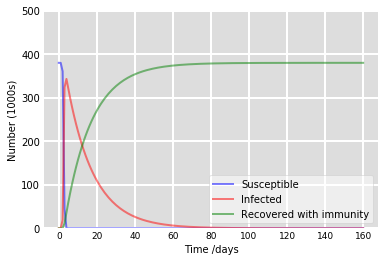

In [18]:
# Total population of Delhi, N.
N = 380500  #0.02*19025023
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 5, 1./14 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,500)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [19]:
print('Infected (I) :' , I)

Infected (I) : [1.00000000e+00 1.42477816e+02 1.92571326e+04 3.24029955e+05
 3.43504164e+05 3.20107964e+05 2.97912048e+05 2.77250329e+05
 2.58021526e+05 2.40126341e+05 2.23472285e+05 2.07973278e+05
 1.93549208e+05 1.80125526e+05 1.67632849e+05 1.56006606e+05
 1.45186706e+05 1.35117225e+05 1.25746116e+05 1.17024944e+05
 1.08908633e+05 1.01355232e+05 9.43257001e+04 8.77837034e+04
 8.16954293e+04 7.60294100e+04 7.07563595e+04 6.58490253e+04
 6.12820402e+04 5.70318004e+04 5.30763374e+04 4.93952072e+04
 4.59693832e+04 4.27811591e+04 3.98140549e+04 3.70527350e+04
 3.44829281e+04 3.20913510e+04 2.98656427e+04 2.77942993e+04
 2.58666147e+04 2.40726254e+04 2.24030590e+04 2.08492860e+04
 1.94032756e+04 1.80575537e+04 1.68051649e+04 1.56396360e+04
 1.45549429e+04 1.35454791e+04 1.26060270e+04 1.17317310e+04
 1.09180722e+04 1.01608449e+04 9.45613551e+03 8.80030149e+03
 8.18995309e+03 7.62193567e+03 7.09331337e+03 6.60135384e+03
 6.14351438e+03 5.71742852e+03 5.32089403e+03 4.95186133e+03
 4.608423

In [20]:
C2 = I[44:63]
print ("Confirmed cases in Delhi as per SIR Model : ", C2)

Confirmed cases in Delhi as per SIR Model :  [19403.27556302 18057.55367005 16805.16490004 15639.63603503
 14554.94287586 13545.47906075 12606.02698556 11731.73099718
 10918.0721534  10160.84492503  9456.13551095  8800.30148623
  8189.95309412  7621.93566884  7093.31336607  6601.35384479
  6143.51438001  5717.42852453  5320.89402698]


### Applying statistical test on the 2 arrays
#### Array 1 : Actual confirmed cases in Delhi during phase 2 of lockdown (C1)
#### Array 2 : Confirmed cases in Delhi during phase 2 of lockdown as per SIR Model (C2)

In [21]:
stats.ttest_ind(C1, C2)

Ttest_indResult(statistic=-8.259218665324049, pvalue=7.900905008917124e-10)

### H-null = 

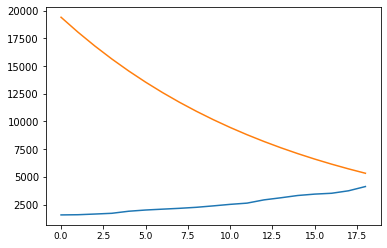

In [22]:
plt.plot(C1) # plotting by columns
plt.plot(C2)
plt.show()

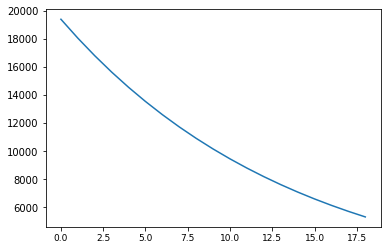

In [23]:
plt.plot(C2) # plotting by columns
plt.show()

### Iteration # 2 : Modeling for Maharashtra

Text(08/06/20, 5000, 'Unlock 1.0')

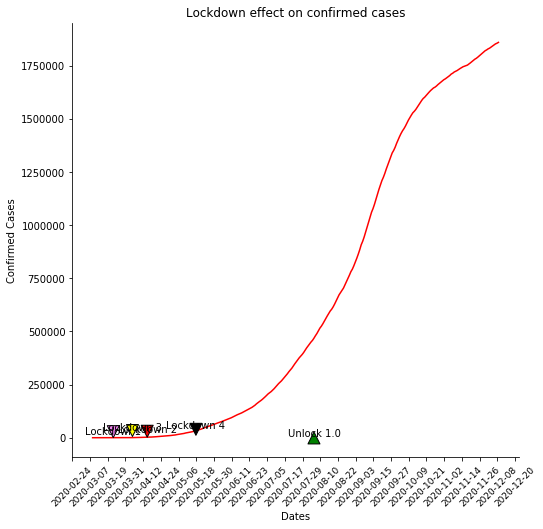

In [24]:
#df_m = pd.read_csv("covid_19_india.csv")
df_m = pd.read_csv("covid_19_india.csv", parse_dates=['Date'],dayfirst=True)
df_mah = df_m[(df_m['State/UnionTerritory']=='Maharashtra')]
plt.figure(figsize=(8,8))
plt.plot(df_mah['Date'],df_mah['Confirmed'],'-r')
plt.rc("xtick",labelsize=9)
plt.rc("ytick",labelsize=10)
ax = plt.gca()
start, end = ax.get_xlim()

ax.xaxis.set_ticks(np.arange(start, end, 12))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.title('Lockdown effect on confirmed cases')
ax.annotate('Lockdown1', xy =('23/03/20',29), xytext=('23/03/20',15000),ha='center',
                arrowprops = dict(facecolor ='Violet',shrink = 0.05),) 
ax.annotate('Lockdown 2', xy =('15/04/20',1561), xytext=('15/04/20',25000),ha='center',
                arrowprops = dict(facecolor ='Red',shrink = 0.05),) 
ax.annotate('Lockdown 3', xy =('04/05/20',4549), xytext=('04/05/20',35000),ha='center', 
                arrowprops = dict(facecolor ='Yellow',shrink = 0.05),) 
ax.annotate('Lockdown 4', xy =('18/05/20',10054), xytext=('18/05/20',45000),ha='center',
                arrowprops = dict(facecolor ='Black',shrink = 0.05),) 
ax.annotate('Unlock 1.0', xy =('08/06/20',27654), xytext=('08/06/20',5000),ha='center',
                arrowprops = dict(facecolor ='Green',shrink = 0.05),) 

In [25]:
df_mah.reset_index(inplace=True)
df_mah['minday']=df_mah['Date'].min()
df_mah['days']=pd.Series(int)
for i in range(len(df_mah)):
    df_mah['days'][i]=(df_mah['Date'][i]-df_mah['minday'][i]).days
df_mah_c=pd.DataFrame()
df_mah_c=df_mah[df_mah['days'].between(44,62)]
C3 = np.array(df_mah_c['Confirmed'])
print ("Reported Confirmed Cases in Delhi : ", C3)

Reported Confirmed Cases in Delhi :  [ 5221  5652  6430  6817  7628  8068  8590  9318  9915 10498 11506 12296
 12974 14541 15525 16758 17974 19063 20228]


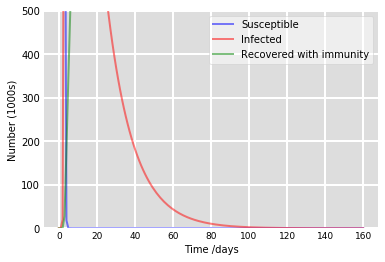

Infected (I) : [1.00000000e+00 1.42524257e+02 2.01514815e+04 1.33819373e+06
 2.36940836e+06 2.22204192e+06 2.06811841e+06 1.92468604e+06
 1.79119874e+06 1.66696945e+06 1.55135613e+06 1.44376121e+06
 1.34362860e+06 1.25044071e+06 1.16371590e+06 1.08300592e+06
 1.00789361e+06 9.37990741e+05 8.72936018e+05 8.12393189e+05
 7.56049335e+05 7.03613234e+05 6.54813860e+05 6.09398987e+05
 5.67133880e+05 5.27800086e+05 4.91194300e+05 4.57127326e+05
 4.25423085e+05 3.95917701e+05 3.68458674e+05 3.42904078e+05
 3.19121833e+05 2.96989015e+05 2.76391220e+05 2.57221999e+05
 2.39382266e+05 2.22779814e+05 2.07328833e+05 1.92949460e+05
 1.79567374e+05 1.67113408e+05 1.55523192e+05 1.44736820e+05
 1.34698540e+05 1.25356470e+05 1.16662323e+05 1.08571161e+05
 1.01041166e+05 9.40334158e+04 8.75116912e+04 8.14422834e+04
 7.57938216e+04 7.05371112e+04 6.56449823e+04 6.10921488e+04
 5.68550789e+04 5.29118725e+04 4.92421488e+04 4.58269402e+04
 4.26485947e+04 3.96906847e+04 3.69379216e+04 3.43760775e+04
 3.199191

In [26]:
# Total population of Maharashtra, N.
N=int(0.02*128466921)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 5, 1./14 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,500)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

print('Infected (I) :' , I)
C4 = I[44:63]
print ("Confirmed cases in Delhi as per SIR Model : ", C2)


In [27]:
stats.ttest_ind(C3, C4)

Ttest_indResult(statistic=-9.17747522308674, pvalue=5.844643706601162e-11)